## BERT

In [1]:
import datetime, os
import pandas as pd
pd.set_option('display.max.colwidth', 100)
import numpy as np
import gensim
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine, cdist
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer

2022-11-11 11:07:59.655188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 11:07:59.655288: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

    def __init__(self, model_dir, path_prefix):
        self.path_prefix = path_prefix
        self.model_dir = model_dir
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        
    def on_train_end(self, model):
        model.save('{}/{}_epoch{}.model'.format(self.model_dir, self.path_prefix, self.epoch))

class EpochLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model3):
        loss = model3.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [3]:
# Smooth Inverse Frequency 
def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in xrange(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [21]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
# contracts = pd.read_excel("../data/Contracts.xlsx")
contracts = pd.read_excel("../data/Contracts_v2.xlsx")
outcomes = pd.DataFrame()
titles = pd.DataFrame()
for year in years:
    temp_outcome = pd.read_excel("../data/EXPORT"+str(year)+".xlsx").set_index('관리번호')
    temp_title = pd.read_excel("../data/"+str(year)+".xlsx").set_index('관리번호')
    outcomes = pd.concat([outcomes, temp_outcome], axis=0)
    titles = pd.concat([titles,temp_title], axis=0)

In [24]:
contracts.columns

Index(['No', '년도', '계약일', '개월수', '계약번호', '계약명칭', '출원인', '업체명', '기업과제 연계 기술이전',
       '업체담당자', '담당자 이메일', '담당자 연락처', '책임발명자', '학과', '차수', '입금일자', '입금액', '합계',
       '기술구분', '실시조건'],
      dtype='object')

In [28]:
contracts[contracts['기업과제 연계 기술이전'].notna()]

,No,년도,계약일,개월수,계약번호,계약명칭,출원인,업체명,기업과제 연계 기술이전,업체담당자,담당자 이메일,담당자 연락처,책임발명자,학과,차수,입금일자,입금액,합계,기술구분,실시조건
7,12.0,2020.0,2020-12-21,5.0,T2020-0037,Neural Network Synaptic Cell 특성 추출을 위한 High-Resolution/Multi-channel ADC 개발 노하우 기술이전,NaN,에스케이하이닉스 주식회사,1.0,NaN,houn.lee@sk.com,NaN,범진욱,전자공학전공,1.0,2020-12-30,25000000.0,100000000.0,Know-How,노하우
14,22.0,2020.0,2020-10-22,7.0,T2020-0026,지정된 역에 PSD를 설치할 때 지역적 기본풍속 및 열차풍이 구조물에 미치는 영향해석 노하우(Know-How) 기술이전,NaN,태창이엔피 주식회사,1.0,NaN,NaN,NaN,허남건,기계공학전공,1.0,2021-01-15,9000000.0,9000000.0,Know-How,노하우
36,52.0,2020.0,2020-02-14,15.0,T2020-0003,지정된 역에 PSD를 설치할 때 지역적 기본풍속 및 열차풍이 구조물에 미치는 영향해석 노하우(Know-How) 기술이전,NaN,태창이엔피 주식회사,1.0,NaN,NaN,NaN,허남건,기계공학전공,1.0,2020-02-21,10500000.0,10500000.0,Know-How,노하우
52,71.0,2019.0,2019-10-28,19.0,T2019-0049,3.5GHz/28GHz 대역 5G 시스템 설계 및 평가 기술 노하우 이전,NaN,㈜케이엠더블유,1.0,NaN,NaN,NaN,윤상원,전자공학전공,1.0,2019-10-31,25000000.0,25000000.0,Know-How,노하우
64,83.0,2019.0,2019-09-19,20.0,T2019-0041,지정된 역에 PSD를 설치할 때 지역적 기본풍속 및 열차풍이 구조물에 미치는 영향해석 노하우(Know-How) 기술이전,NaN,태창이엔피 주식회사,1.0,NaN,NaN,NaN,허남건,기계공학전공,1.0,2019-09-25,6000000.0,6000000.0,Know-How,노하우
86,108.0,2019.0,2019-07-12,22.0,T2019-0018,방사능 누출 영상감시 감마카메라용 검출기 및 아날로그 신호처리 보드,NaN,주식회사우진엔텍,1.0,NaN,NaN,NaN,최용,전자공학전공,1.0,2019-08-09,8000000.0,8000000.0,Know-How,노하우
102,129.0,2019.0,2019-01-02,28.0,T2019-0001,핵의학 영상기기 기반 융합영상기기용 DAQ 모듈 개발,NaN,주식회사우진엔텍,1.0,NaN,NaN,NaN,최용,전자공학전공,1.0,2019-01-11,9090909.0,9090909.0,Know-How,노하우
104,131.0,2018.0,2018-12-31,29.0,T2018-0074,자연어 대화 데이터 및 수집 방법,NaN,현대엔지비(주),1.0,NaN,NaN,NaN,서정연,컴퓨터공학전공,2.0,2019-04-19,32000000.0,80000000.0,Know-How,노하우
114,143.0,2018.0,2018-12-14,29.0,T2018-0059,핵의학 영상기기 기반 융합영상기기용 DAQ 모듈 개발 노하우(Know-How) 기술이전,NaN,주식회사우진엔텍,1.0,김종호,gamma77@korea.com,0313793610,최용,전자공학전공,1.0,NaT,NaN,0.0,Know-How,노하우
129,160.0,2018.0,2018-11-01,30.0,T2018-0045,지능형 반도체 시스템 응용을 위한 저전력 고속 SAR ADC 기술 개발 및 이전,NaN,에스케이하이닉스 주식회사,1.0,NaN,houn.lee@sk.com,NaN,이승훈,전자공학전공,4.0,2020-12-31,25000000.0,100000000.0,Know-How,노하우


In [8]:
outcomes = pd.concat([outcomes, titles['제목(영어)']], axis=1)
outcomes = outcomes[['예외', '학년도', '성과물구분', '성과물구분명', '기준일', '제목', '제목(영어)', '상위소속명', '소속명', '교직원번호',
       '성명', '관련연구과제', '발송여부', '성과물확인', '교원업적', '자료제출방법', '연동여부(KRI)', '검증여부',
       '전송일시(KRI)', '총저자수']]

In [9]:
outcomes.head()

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
20646,NaN,2015,1,논문,2015-05-30,YouTube acceptance by university educators and students: a cross-cultural perspective,YouTube acceptance by university educators and students: a cross-cultural perspective,특수대학원,교육대학원,111217,이예경,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21054,NaN,2015,1,논문,2015-10-01,Emotional information processing based on feature vector enhancement and selection for human-com...,Emotional information processing based on feature vector enhancement and selection for human-com...,공학부,컴퓨터공학전공,101623,김지환,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21110,NaN,2015,1,논문,2015-04-01,Controller Design for Mechanical Impedance Reduction,Controller Design for Mechanical Impedance Reduction,공학부,기계공학전공,111847,공경철,201431009.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21597,NaN,2015,1,논문,2015-05-01,Perceived stigma of alcohol dependency: comparative influence on patients and family members,Perceived stigma of alcohol dependency: comparative influence on patients and family members,전문대학원,경영전문대학원,101434,신호창,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,3
21636,NaN,2015,1,논문,2015-12-21,Multisensory fashion communication media towards impression management,Multisensory fashion communication media towards impression management,전문대학원,영상대학원,113308,최용순,201310044.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2


In [10]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
title_inv = inventions['제목(영어)'].drop_duplicates(keep='first')

In [11]:
outcomes_tech = outcomes[outcomes['성과물구분명']=='기술이전']
title_tech = []
index_tech = []
technologies = []
for i in tqdm(range(len(outcomes_tech))):
    if outcomes_tech.iloc[i]['제목'] in list(contracts['계약명칭']):
#         print(outcomes_tech.iloc[i]['성명'], contracts.iloc[list(contracts['계약명칭']).index(outcomes_tech.iloc[i]['제목'])]['책임발명자'])
        title_tech.append(outcomes_tech.iloc[i]['제목(영어)'])
        index_tech.append(outcomes_tech.iloc[i].name)
        index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]
        technologies.append(pd.concat([pd.Series(outcomes_tech.iloc[i].name).rename({0: "관리번호"}), pd.Series(outcomes_tech.iloc[i]['제목(영어)']).rename({0: "제목"}), contracts.loc[contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]]]))
title_tech = pd.Series(title_tech, index=index_tech).drop_duplicates(keep='first')
technologies = pd.concat(technologies, axis=1).T
technologies = technologies.drop(technologies['학과'][technologies['학과'].isna()].index)

100%|██████████| 631/631 [00:03<00:00, 177.46it/s]


In [12]:
name_idx = pd.Series(np.union1d(technologies['책임발명자'].unique(), inventions['성명'].unique()))
idx_name = pd.Series(name_idx.index, index=list(name_idx))
depart_idx = pd.Series(np.union1d(technologies['학과'].unique().astype('str')[technologies['학과'].unique().astype('str')!='nan'], inventions['소속명'].unique()))
idx_depart = pd.Series(depart_idx.index, index=list(depart_idx))
use_cols_inv = ['성과물구분명', '기준일', '제목(영어)', '소속명', 'depart_idx', '성명', 'name_idx']
use_cols_tech = ['관리번호', '기술구분', '계약일', '제목', '학과', 'depart_idx', '책임발명자', 'name_idx']

In [13]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
inventions = pd.concat([inventions, pd.Series(map(lambda x: idx_name.loc[x], list(inventions['성명'])), index=inventions.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(inventions['소속명'])), index=inventions.index).rename("depart_idx")], axis=1)[use_cols_inv]
inventions = inventions.rename({'제목(영어)': 'title', '소속명': 'department', '성명': 'name', '기준일': 'date', '성과물구분명': 'type'}, axis=1)
inventions.index.name = 'inv_no'
title_inv = inventions['title'].drop_duplicates(keep='first')
inventions = inventions.loc[title_inv.index]

In [14]:
technologies = pd.concat([technologies, pd.Series(map(lambda x: idx_name.loc[x], list(technologies['책임발명자'])), index=technologies.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(technologies['학과'])), index=technologies.index).rename("depart_idx")], axis=1)[use_cols_tech]
technologies = technologies.rename({'관리번호': 'tech_no', '기술구분': 'type', '계약일': 'date', '제목': 'title', '학과': 'department', '책임발명자': 'name'}, axis=1)
technologies = technologies.set_index('tech_no')

In [15]:
inventions.head()

,type,date,title,department,depart_idx,name,name_idx
inv_no,,,,,,,
20646,논문,2015-05-30,YouTube acceptance by university educators and students: a cross-cultural perspective,교육대학원,8,이예경,398
21054,논문,2015-10-01,Emotional information processing based on feature vector enhancement and selection for human-com...,컴퓨터공학전공,60,김지환,150
21110,논문,2015-04-01,Controller Design for Mechanical Impedance Reduction,기계공학전공,14,공경철,53
21597,논문,2015-05-01,Perceived stigma of alcohol dependency: comparative influence on patients and family members,경영전문대학원,2,신호창,292
21636,논문,2015-12-21,Multisensory fashion communication media towards impression management,영상대학원,49,최용순,575


In [16]:
inventions.shape

(16517, 7)

In [18]:
technologies.head()

,type,date,title,department,depart_idx,name,name_idx
tech_no,,,,,,,
5000000737,Know-How,2015-01-30,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,전자공학전공,53,범진욱,246
5000000739,Know-How,2015-03-01,12b low-power SAR-type ADC IP(3종),전자공학전공,53,이승훈,394
5000000740,Know-How,2015-03-27,Improving image sensor design capabilities and transferring know-how to improve image quality,전자공학전공,53,최희철,591
5000000741,Know-How,2015-08-04,"Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...",기계공학전공,14,손기헌,268
5000000751,Know-How,2015-08-03,Know-how technology transfer for technology search system development,컴퓨터공학전공,60,박운상,224


In [19]:
technologies.shape

(565, 7)

In [29]:
index_inv = title_inv.index
index_tech = title_tech.index
print("#research: {}, #technology: {}".format(len(inventions), len(technologies)))

#research: 16517, #technology: 565


In [30]:
text = "&ADSF-"
re.findall('[a-zA-Z0-9\-\__]+', text)

['ADSF-']

In [31]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ['A', 'The', '-']

def no_nums(text):
    return ' '.join(filter(lambda word:word.replace('.','').replace(',','').isdigit()==False, text.split()))

def extract_word(text):
#     text = no_nums(text)
#     word_list = re.findall('[a-zA-Z0-9\-\__]+', text)
    word_list = re.findall('[a-zA-Z0-9]+', text)
    word_list = [word for word in word_list if word not in stop_words]
    word_list = [word for word in word_list if not word.isdigit()]
    return word_list

def remove_rare_words(word_list):
    out = [word for word in word_list if word not in rare_words]
    if out == []:
        return ['_NOWORDS_']
    else:
        return out
    
def word_padding(word_list):
    if len(word_list)<2:
        return word_list*2
    else:
        return word_list

# def remove_rare_words(title_list, rare_words):
#     output, noword_index = [], []
#     for i in tqdm(range(len(title_list))):
#         word_list = title_list[i]
#         temp = [word for word in word_list if word not in rare_words]
#         if temp == []:
#             noword_index.append(i)
#         else:
#             output.append(temp)
#     return output

def calc_vec(model, title_list, method='avg', list_total=None, alpha=1e-3):
    if method=='sbert':
        return pd.Series(list(model.encode(title_list.values, convert_to_tensor=False)), index=title_list.index)
#         return list(model.encode(title_list.values, convert_to_tensor=False))
    else:
        out_vec = []
        if method in ['sif', 'sif_weight']:
            words_unq, words_weights = np.unique(list_total, return_counts=True)
            if method=='sif_weight':
                words_weights = words_weights / len(list_total)
                words_weights = alpha / (alpha + words_weights)
            else:
                words_weights = words_weights / len(list_total)
        for word_list in tqdm(title_list):
            if method=='avg':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sum':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.sum(sentence_vec, axis=0))
            elif method=='sif':
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = np.array([model.wv[word] for word in word_list])
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sif_weight':
                ww_s = np.array([words_weights[np.where(words_unq==word)[0][0]] for word in word_list])
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = ww_s.dot(wv_s) / np.count_nonzero(ww_s)
                out_vec.append(sentence_vec)
        if method in ['sif', 'sif_weight']:
            out_vec = np.array(out_vec)
            out_vec = list(remove_pc(out_vec, 1))
        return pd.Series(out_vec, index=title_list.index)

def get_loc(df, index):
    return df.index[index]

def get_iloc(df, index):
    return list(df.index).index(index)

def calc_rank(vec_tech, vec_inv, topk=5):
    index_inv = vec_inv.index
    index_tech = vec_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    top_candidates = {}
    for id_target in tqdm(vec_tech.index):
        top_candidates[id_target] = {}
        iloc_target = get_iloc(vec_tech, id_target)
        top_invention = inventions.loc[index_inv[np.argsort(dist_list[iloc_target])]]['name'].drop_duplicates(keep='first')[:topk].index
        top_candidates[id_target]['title'] = inventions.loc[top_invention]['title']
        top_candidates[id_target]['inventor'] = inventions.loc[top_invention]['name']
        top_candidates[id_target]['department'] = inventions.loc[top_invention]['department']
        top_candidates[id_target]['inventor_idx'] = inventions.loc[top_invention]['name_idx']
        top_candidates[id_target]['department_idx'] = inventions.loc[top_invention]['depart_idx']
        top_candidates[id_target]['distance'] = pd.Series(dist_list[iloc_target], index=vec_inv.index).loc[top_invention]
    return top_candidates

In [32]:
list_inv = pd.Series(list(map(extract_word, title_inv)), index=index_inv)
list_tech = pd.Series(list(map(extract_word, title_tech)), index=index_tech)
list_total = sum((list(list_tech)+list(list_inv)), [])

words_unq, words_counts = np.unique(list_total, return_counts=True)
rare_words = words_unq[words_counts==1]

list_inv = list_inv.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_inv.values) if '_NOWORDS_' not in l]
list_inv = list_inv.iloc[temp_index]
list_inv = list_inv.map(word_padding)

list_tech = list_tech.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_tech.values) if '_NOWORDS_' not in l]
list_tech = list_tech.iloc[temp_index]
list_tech = list_tech.map(word_padding)

list_total = sum((list(list_tech)+list(list_inv)), [])

sentences_to_train = list(pd.concat([list_inv, list_tech]))

In [34]:
np.unique(list_total)

(12573,)

In [541]:
MODEL_DIR="../models"

model_type_to_load = input("Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): ")
if model_type_to_load in ['1', 'load_pretrained']:
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['2', 'load_transfer']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_transfer_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)    
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_transfer_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_transfer_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['3', 'load_new']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_new_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_new_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_additional_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['4', 'train_transfer']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Before building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    print(f"== BUILD vocab START at {datetime.datetime.now()}")
    ft_model.build_vocab(sentences_to_train, update=True, keep_raw_vocab=True)
    print(f"== BUILD vocab END at {datetime.datetime.now()}")
    print("After building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_additional')
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train, 
                   total_examples=len(sentences_to_train),
                   epochs=n_epochs,
                   compute_loss=True,
                   callbacks=[epoch_saver, epoch_logger]
                  )
elif model_type_to_load in ['5', 'train_new']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    vector_size = input("Vector size: ")
    vector_size = int(vector_size)
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size, window=7, workers=4, negative=7)
    ft_model.build_vocab(sentences_to_train)
    print("Vocab size",len(ft_model.wv.key_to_index))
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False,
           callbacks=[epoch_saver, epoch_logger])

Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): 5
#epochs: 10000
Vector size: 300
Vocab size 12573
Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0
Loss after epoch 20: 0.0
Loss after epoch 21: 0.0
Loss after epoch 22: 0.0
Loss after epoch 23: 0.0
Loss after epoch 24: 0.0
Loss after epoch 25: 0.0
Loss after epoch 26: 0.0
Loss after epoch 27: 0.0
Loss after epoch 28: 0.0
Loss after epoch 29: 0.0
Loss after epoch 30: 0.0
Loss after epoch 31: 0.0
Loss after epoch 32: 0.0
Loss after epoch 33

Loss after epoch 313: 0.0
Loss after epoch 314: 0.0
Loss after epoch 315: 0.0
Loss after epoch 316: 0.0
Loss after epoch 317: 0.0
Loss after epoch 318: 0.0
Loss after epoch 319: 0.0
Loss after epoch 320: 0.0
Loss after epoch 321: 0.0
Loss after epoch 322: 0.0
Loss after epoch 323: 0.0
Loss after epoch 324: 0.0
Loss after epoch 325: 0.0
Loss after epoch 326: 0.0
Loss after epoch 327: 0.0
Loss after epoch 328: 0.0
Loss after epoch 329: 0.0
Loss after epoch 330: 0.0
Loss after epoch 331: 0.0
Loss after epoch 332: 0.0
Loss after epoch 333: 0.0
Loss after epoch 334: 0.0
Loss after epoch 335: 0.0
Loss after epoch 336: 0.0
Loss after epoch 337: 0.0
Loss after epoch 338: 0.0
Loss after epoch 339: 0.0
Loss after epoch 340: 0.0
Loss after epoch 341: 0.0
Loss after epoch 342: 0.0
Loss after epoch 343: 0.0
Loss after epoch 344: 0.0
Loss after epoch 345: 0.0
Loss after epoch 346: 0.0
Loss after epoch 347: 0.0
Loss after epoch 348: 0.0
Loss after epoch 349: 0.0
Loss after epoch 350: 0.0
Loss after e

Loss after epoch 629: 0.0
Loss after epoch 630: 0.0
Loss after epoch 631: 0.0
Loss after epoch 632: 0.0
Loss after epoch 633: 0.0
Loss after epoch 634: 0.0
Loss after epoch 635: 0.0
Loss after epoch 636: 0.0
Loss after epoch 637: 0.0
Loss after epoch 638: 0.0
Loss after epoch 639: 0.0
Loss after epoch 640: 0.0
Loss after epoch 641: 0.0
Loss after epoch 642: 0.0
Loss after epoch 643: 0.0
Loss after epoch 644: 0.0
Loss after epoch 645: 0.0
Loss after epoch 646: 0.0
Loss after epoch 647: 0.0
Loss after epoch 648: 0.0
Loss after epoch 649: 0.0
Loss after epoch 650: 0.0
Loss after epoch 651: 0.0
Loss after epoch 652: 0.0
Loss after epoch 653: 0.0
Loss after epoch 654: 0.0
Loss after epoch 655: 0.0
Loss after epoch 656: 0.0
Loss after epoch 657: 0.0
Loss after epoch 658: 0.0
Loss after epoch 659: 0.0
Loss after epoch 660: 0.0
Loss after epoch 661: 0.0
Loss after epoch 662: 0.0
Loss after epoch 663: 0.0
Loss after epoch 664: 0.0
Loss after epoch 665: 0.0
Loss after epoch 666: 0.0
Loss after e

Loss after epoch 945: 0.0
Loss after epoch 946: 0.0
Loss after epoch 947: 0.0
Loss after epoch 948: 0.0
Loss after epoch 949: 0.0
Loss after epoch 950: 0.0
Loss after epoch 951: 0.0
Loss after epoch 952: 0.0
Loss after epoch 953: 0.0
Loss after epoch 954: 0.0
Loss after epoch 955: 0.0
Loss after epoch 956: 0.0
Loss after epoch 957: 0.0
Loss after epoch 958: 0.0
Loss after epoch 959: 0.0
Loss after epoch 960: 0.0
Loss after epoch 961: 0.0
Loss after epoch 962: 0.0
Loss after epoch 963: 0.0
Loss after epoch 964: 0.0
Loss after epoch 965: 0.0
Loss after epoch 966: 0.0
Loss after epoch 967: 0.0
Loss after epoch 968: 0.0
Loss after epoch 969: 0.0
Loss after epoch 970: 0.0
Loss after epoch 971: 0.0
Loss after epoch 972: 0.0
Loss after epoch 973: 0.0
Loss after epoch 974: 0.0
Loss after epoch 975: 0.0
Loss after epoch 976: 0.0
Loss after epoch 977: 0.0
Loss after epoch 978: 0.0
Loss after epoch 979: 0.0
Loss after epoch 980: 0.0
Loss after epoch 981: 0.0
Loss after epoch 982: 0.0
Loss after e

Loss after epoch 1251: 0.0
Loss after epoch 1252: 0.0
Loss after epoch 1253: 0.0
Loss after epoch 1254: 0.0
Loss after epoch 1255: 0.0
Loss after epoch 1256: 0.0
Loss after epoch 1257: 0.0
Loss after epoch 1258: 0.0
Loss after epoch 1259: 0.0
Loss after epoch 1260: 0.0
Loss after epoch 1261: 0.0
Loss after epoch 1262: 0.0
Loss after epoch 1263: 0.0
Loss after epoch 1264: 0.0
Loss after epoch 1265: 0.0
Loss after epoch 1266: 0.0
Loss after epoch 1267: 0.0
Loss after epoch 1268: 0.0
Loss after epoch 1269: 0.0
Loss after epoch 1270: 0.0
Loss after epoch 1271: 0.0
Loss after epoch 1272: 0.0
Loss after epoch 1273: 0.0
Loss after epoch 1274: 0.0
Loss after epoch 1275: 0.0
Loss after epoch 1276: 0.0
Loss after epoch 1277: 0.0
Loss after epoch 1278: 0.0
Loss after epoch 1279: 0.0
Loss after epoch 1280: 0.0
Loss after epoch 1281: 0.0
Loss after epoch 1282: 0.0
Loss after epoch 1283: 0.0
Loss after epoch 1284: 0.0
Loss after epoch 1285: 0.0
Loss after epoch 1286: 0.0
Loss after epoch 1287: 0.0
L

Loss after epoch 1555: 0.0
Loss after epoch 1556: 0.0
Loss after epoch 1557: 0.0
Loss after epoch 1558: 0.0
Loss after epoch 1559: 0.0
Loss after epoch 1560: 0.0
Loss after epoch 1561: 0.0
Loss after epoch 1562: 0.0
Loss after epoch 1563: 0.0
Loss after epoch 1564: 0.0
Loss after epoch 1565: 0.0
Loss after epoch 1566: 0.0
Loss after epoch 1567: 0.0
Loss after epoch 1568: 0.0
Loss after epoch 1569: 0.0
Loss after epoch 1570: 0.0
Loss after epoch 1571: 0.0
Loss after epoch 1572: 0.0
Loss after epoch 1573: 0.0
Loss after epoch 1574: 0.0
Loss after epoch 1575: 0.0
Loss after epoch 1576: 0.0
Loss after epoch 1577: 0.0
Loss after epoch 1578: 0.0
Loss after epoch 1579: 0.0
Loss after epoch 1580: 0.0
Loss after epoch 1581: 0.0
Loss after epoch 1582: 0.0
Loss after epoch 1583: 0.0
Loss after epoch 1584: 0.0
Loss after epoch 1585: 0.0
Loss after epoch 1586: 0.0
Loss after epoch 1587: 0.0
Loss after epoch 1588: 0.0
Loss after epoch 1589: 0.0
Loss after epoch 1590: 0.0
Loss after epoch 1591: 0.0
L

Loss after epoch 1859: 0.0
Loss after epoch 1860: 0.0
Loss after epoch 1861: 0.0
Loss after epoch 1862: 0.0
Loss after epoch 1863: 0.0
Loss after epoch 1864: 0.0
Loss after epoch 1865: 0.0
Loss after epoch 1866: 0.0
Loss after epoch 1867: 0.0
Loss after epoch 1868: 0.0
Loss after epoch 1869: 0.0
Loss after epoch 1870: 0.0
Loss after epoch 1871: 0.0
Loss after epoch 1872: 0.0
Loss after epoch 1873: 0.0
Loss after epoch 1874: 0.0
Loss after epoch 1875: 0.0
Loss after epoch 1876: 0.0
Loss after epoch 1877: 0.0
Loss after epoch 1878: 0.0
Loss after epoch 1879: 0.0
Loss after epoch 1880: 0.0
Loss after epoch 1881: 0.0
Loss after epoch 1882: 0.0
Loss after epoch 1883: 0.0
Loss after epoch 1884: 0.0
Loss after epoch 1885: 0.0
Loss after epoch 1886: 0.0
Loss after epoch 1887: 0.0
Loss after epoch 1888: 0.0
Loss after epoch 1889: 0.0
Loss after epoch 1890: 0.0
Loss after epoch 1891: 0.0
Loss after epoch 1892: 0.0
Loss after epoch 1893: 0.0
Loss after epoch 1894: 0.0
Loss after epoch 1895: 0.0
L

Loss after epoch 2163: 0.0
Loss after epoch 2164: 0.0
Loss after epoch 2165: 0.0
Loss after epoch 2166: 0.0
Loss after epoch 2167: 0.0
Loss after epoch 2168: 0.0
Loss after epoch 2169: 0.0
Loss after epoch 2170: 0.0
Loss after epoch 2171: 0.0
Loss after epoch 2172: 0.0
Loss after epoch 2173: 0.0
Loss after epoch 2174: 0.0
Loss after epoch 2175: 0.0
Loss after epoch 2176: 0.0
Loss after epoch 2177: 0.0
Loss after epoch 2178: 0.0
Loss after epoch 2179: 0.0
Loss after epoch 2180: 0.0
Loss after epoch 2181: 0.0
Loss after epoch 2182: 0.0
Loss after epoch 2183: 0.0
Loss after epoch 2184: 0.0
Loss after epoch 2185: 0.0
Loss after epoch 2186: 0.0
Loss after epoch 2187: 0.0
Loss after epoch 2188: 0.0
Loss after epoch 2189: 0.0
Loss after epoch 2190: 0.0
Loss after epoch 2191: 0.0
Loss after epoch 2192: 0.0
Loss after epoch 2193: 0.0
Loss after epoch 2194: 0.0
Loss after epoch 2195: 0.0
Loss after epoch 2196: 0.0
Loss after epoch 2197: 0.0
Loss after epoch 2198: 0.0
Loss after epoch 2199: 0.0
L

Loss after epoch 2467: 0.0
Loss after epoch 2468: 0.0
Loss after epoch 2469: 0.0
Loss after epoch 2470: 0.0
Loss after epoch 2471: 0.0
Loss after epoch 2472: 0.0
Loss after epoch 2473: 0.0
Loss after epoch 2474: 0.0
Loss after epoch 2475: 0.0
Loss after epoch 2476: 0.0
Loss after epoch 2477: 0.0
Loss after epoch 2478: 0.0
Loss after epoch 2479: 0.0
Loss after epoch 2480: 0.0
Loss after epoch 2481: 0.0
Loss after epoch 2482: 0.0
Loss after epoch 2483: 0.0
Loss after epoch 2484: 0.0
Loss after epoch 2485: 0.0
Loss after epoch 2486: 0.0
Loss after epoch 2487: 0.0
Loss after epoch 2488: 0.0
Loss after epoch 2489: 0.0
Loss after epoch 2490: 0.0
Loss after epoch 2491: 0.0
Loss after epoch 2492: 0.0
Loss after epoch 2493: 0.0
Loss after epoch 2494: 0.0
Loss after epoch 2495: 0.0
Loss after epoch 2496: 0.0
Loss after epoch 2497: 0.0
Loss after epoch 2498: 0.0
Loss after epoch 2499: 0.0
Loss after epoch 2500: 0.0
Loss after epoch 2501: 0.0
Loss after epoch 2502: 0.0
Loss after epoch 2503: 0.0
L

Loss after epoch 2771: 0.0
Loss after epoch 2772: 0.0
Loss after epoch 2773: 0.0
Loss after epoch 2774: 0.0
Loss after epoch 2775: 0.0
Loss after epoch 2776: 0.0
Loss after epoch 2777: 0.0
Loss after epoch 2778: 0.0
Loss after epoch 2779: 0.0
Loss after epoch 2780: 0.0
Loss after epoch 2781: 0.0
Loss after epoch 2782: 0.0
Loss after epoch 2783: 0.0
Loss after epoch 2784: 0.0
Loss after epoch 2785: 0.0
Loss after epoch 2786: 0.0
Loss after epoch 2787: 0.0
Loss after epoch 2788: 0.0
Loss after epoch 2789: 0.0
Loss after epoch 2790: 0.0
Loss after epoch 2791: 0.0
Loss after epoch 2792: 0.0
Loss after epoch 2793: 0.0
Loss after epoch 2794: 0.0
Loss after epoch 2795: 0.0
Loss after epoch 2796: 0.0
Loss after epoch 2797: 0.0
Loss after epoch 2798: 0.0
Loss after epoch 2799: 0.0
Loss after epoch 2800: 0.0
Loss after epoch 2801: 0.0
Loss after epoch 2802: 0.0
Loss after epoch 2803: 0.0
Loss after epoch 2804: 0.0
Loss after epoch 2805: 0.0
Loss after epoch 2806: 0.0
Loss after epoch 2807: 0.0
L

Loss after epoch 3075: 0.0
Loss after epoch 3076: 0.0
Loss after epoch 3077: 0.0
Loss after epoch 3078: 0.0
Loss after epoch 3079: 0.0
Loss after epoch 3080: 0.0
Loss after epoch 3081: 0.0
Loss after epoch 3082: 0.0
Loss after epoch 3083: 0.0
Loss after epoch 3084: 0.0
Loss after epoch 3085: 0.0
Loss after epoch 3086: 0.0
Loss after epoch 3087: 0.0
Loss after epoch 3088: 0.0
Loss after epoch 3089: 0.0
Loss after epoch 3090: 0.0
Loss after epoch 3091: 0.0
Loss after epoch 3092: 0.0
Loss after epoch 3093: 0.0
Loss after epoch 3094: 0.0
Loss after epoch 3095: 0.0
Loss after epoch 3096: 0.0
Loss after epoch 3097: 0.0
Loss after epoch 3098: 0.0
Loss after epoch 3099: 0.0
Loss after epoch 3100: 0.0
Loss after epoch 3101: 0.0
Loss after epoch 3102: 0.0
Loss after epoch 3103: 0.0
Loss after epoch 3104: 0.0
Loss after epoch 3105: 0.0
Loss after epoch 3106: 0.0
Loss after epoch 3107: 0.0
Loss after epoch 3108: 0.0
Loss after epoch 3109: 0.0
Loss after epoch 3110: 0.0
Loss after epoch 3111: 0.0
L

Loss after epoch 3379: 0.0
Loss after epoch 3380: 0.0
Loss after epoch 3381: 0.0
Loss after epoch 3382: 0.0
Loss after epoch 3383: 0.0
Loss after epoch 3384: 0.0
Loss after epoch 3385: 0.0
Loss after epoch 3386: 0.0
Loss after epoch 3387: 0.0
Loss after epoch 3388: 0.0
Loss after epoch 3389: 0.0
Loss after epoch 3390: 0.0
Loss after epoch 3391: 0.0
Loss after epoch 3392: 0.0
Loss after epoch 3393: 0.0
Loss after epoch 3394: 0.0
Loss after epoch 3395: 0.0
Loss after epoch 3396: 0.0
Loss after epoch 3397: 0.0
Loss after epoch 3398: 0.0
Loss after epoch 3399: 0.0
Loss after epoch 3400: 0.0
Loss after epoch 3401: 0.0
Loss after epoch 3402: 0.0
Loss after epoch 3403: 0.0
Loss after epoch 3404: 0.0
Loss after epoch 3405: 0.0
Loss after epoch 3406: 0.0
Loss after epoch 3407: 0.0
Loss after epoch 3408: 0.0
Loss after epoch 3409: 0.0
Loss after epoch 3410: 0.0
Loss after epoch 3411: 0.0
Loss after epoch 3412: 0.0
Loss after epoch 3413: 0.0
Loss after epoch 3414: 0.0
Loss after epoch 3415: 0.0
L

Loss after epoch 3683: 0.0
Loss after epoch 3684: 0.0
Loss after epoch 3685: 0.0
Loss after epoch 3686: 0.0
Loss after epoch 3687: 0.0
Loss after epoch 3688: 0.0
Loss after epoch 3689: 0.0
Loss after epoch 3690: 0.0
Loss after epoch 3691: 0.0
Loss after epoch 3692: 0.0
Loss after epoch 3693: 0.0
Loss after epoch 3694: 0.0
Loss after epoch 3695: 0.0
Loss after epoch 3696: 0.0
Loss after epoch 3697: 0.0
Loss after epoch 3698: 0.0
Loss after epoch 3699: 0.0
Loss after epoch 3700: 0.0
Loss after epoch 3701: 0.0
Loss after epoch 3702: 0.0
Loss after epoch 3703: 0.0
Loss after epoch 3704: 0.0
Loss after epoch 3705: 0.0
Loss after epoch 3706: 0.0
Loss after epoch 3707: 0.0
Loss after epoch 3708: 0.0
Loss after epoch 3709: 0.0
Loss after epoch 3710: 0.0
Loss after epoch 3711: 0.0
Loss after epoch 3712: 0.0
Loss after epoch 3713: 0.0
Loss after epoch 3714: 0.0
Loss after epoch 3715: 0.0
Loss after epoch 3716: 0.0
Loss after epoch 3717: 0.0
Loss after epoch 3718: 0.0
Loss after epoch 3719: 0.0
L

Loss after epoch 3987: 0.0
Loss after epoch 3988: 0.0
Loss after epoch 3989: 0.0
Loss after epoch 3990: 0.0
Loss after epoch 3991: 0.0
Loss after epoch 3992: 0.0
Loss after epoch 3993: 0.0
Loss after epoch 3994: 0.0
Loss after epoch 3995: 0.0
Loss after epoch 3996: 0.0
Loss after epoch 3997: 0.0
Loss after epoch 3998: 0.0
Loss after epoch 3999: 0.0
Loss after epoch 4000: 0.0
Loss after epoch 4001: 0.0
Loss after epoch 4002: 0.0
Loss after epoch 4003: 0.0
Loss after epoch 4004: 0.0
Loss after epoch 4005: 0.0
Loss after epoch 4006: 0.0
Loss after epoch 4007: 0.0
Loss after epoch 4008: 0.0
Loss after epoch 4009: 0.0
Loss after epoch 4010: 0.0
Loss after epoch 4011: 0.0
Loss after epoch 4012: 0.0
Loss after epoch 4013: 0.0
Loss after epoch 4014: 0.0
Loss after epoch 4015: 0.0
Loss after epoch 4016: 0.0
Loss after epoch 4017: 0.0
Loss after epoch 4018: 0.0
Loss after epoch 4019: 0.0
Loss after epoch 4020: 0.0
Loss after epoch 4021: 0.0
Loss after epoch 4022: 0.0
Loss after epoch 4023: 0.0
L

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss after epoch 6474: 0.0
Loss after epoch 6475: 0.0
Loss after epoch 6476: 0.0
Loss after epoch 6477: 0.0
Loss after epoch 6478: 0.0
Loss after epoch 6479: 0.0
Loss after epoch 6480: 0.0
Loss after epoch 6481: 0.0
Loss after epoch 6482: 0.0
Loss after epoch 6483: 0.0
Loss after epoch 6484: 0.0
Loss after epoch 6485: 0.0
Loss after epoch 6486: 0.0
Loss after epoch 6487: 0.0
Loss after epoch 6488: 0.0
Loss after epoch 6489: 0.0
Loss after epoch 6490: 0.0
Loss after epoch 6491: 0.0
Loss after epoch 6492: 0.0
Loss after epoch 6493: 0.0
Loss after epoch 6494: 0.0
Loss after epoch 6495: 0.0
Loss after epoch 6496: 0.0
Loss after epoch 6497: 0.0
Loss after epoch 6498: 0.0
Loss after epoch 6499: 0.0
Loss after epoch 6500: 0.0
Loss after epoch 6501: 0.0
Loss after epoch 6502: 0.0
Loss after epoch 6503: 0.0
Loss after epoch 6504: 0.0
Loss after epoch 6505: 0.0
Loss after epoch 6506: 0.0
Loss after epoch 6507: 0.0
Loss after epoch 6508: 0.0
Loss after epoch 6509: 0.0
Loss after epoch 6510: 0.0
L

Loss after epoch 6778: 0.0
Loss after epoch 6779: 0.0
Loss after epoch 6780: 0.0
Loss after epoch 6781: 0.0
Loss after epoch 6782: 0.0
Loss after epoch 6783: 0.0
Loss after epoch 6784: 0.0
Loss after epoch 6785: 0.0
Loss after epoch 6786: 0.0
Loss after epoch 6787: 0.0
Loss after epoch 6788: 0.0
Loss after epoch 6789: 0.0
Loss after epoch 6790: 0.0
Loss after epoch 6791: 0.0
Loss after epoch 6792: 0.0
Loss after epoch 6793: 0.0
Loss after epoch 6794: 0.0
Loss after epoch 6795: 0.0
Loss after epoch 6796: 0.0
Loss after epoch 6797: 0.0
Loss after epoch 6798: 0.0
Loss after epoch 6799: 0.0
Loss after epoch 6800: 0.0
Loss after epoch 6801: 0.0
Loss after epoch 6802: 0.0
Loss after epoch 6803: 0.0
Loss after epoch 6804: 0.0
Loss after epoch 6805: 0.0
Loss after epoch 6806: 0.0
Loss after epoch 6807: 0.0
Loss after epoch 6808: 0.0
Loss after epoch 6809: 0.0
Loss after epoch 6810: 0.0
Loss after epoch 6811: 0.0
Loss after epoch 6812: 0.0
Loss after epoch 6813: 0.0
Loss after epoch 6814: 0.0
L

Loss after epoch 7082: 0.0
Loss after epoch 7083: 0.0
Loss after epoch 7084: 0.0
Loss after epoch 7085: 0.0
Loss after epoch 7086: 0.0
Loss after epoch 7087: 0.0
Loss after epoch 7088: 0.0
Loss after epoch 7089: 0.0
Loss after epoch 7090: 0.0
Loss after epoch 7091: 0.0
Loss after epoch 7092: 0.0
Loss after epoch 7093: 0.0
Loss after epoch 7094: 0.0
Loss after epoch 7095: 0.0
Loss after epoch 7096: 0.0
Loss after epoch 7097: 0.0
Loss after epoch 7098: 0.0
Loss after epoch 7099: 0.0
Loss after epoch 7100: 0.0
Loss after epoch 7101: 0.0
Loss after epoch 7102: 0.0
Loss after epoch 7103: 0.0
Loss after epoch 7104: 0.0
Loss after epoch 7105: 0.0
Loss after epoch 7106: 0.0
Loss after epoch 7107: 0.0
Loss after epoch 7108: 0.0
Loss after epoch 7109: 0.0
Loss after epoch 7110: 0.0
Loss after epoch 7111: 0.0
Loss after epoch 7112: 0.0
Loss after epoch 7113: 0.0
Loss after epoch 7114: 0.0
Loss after epoch 7115: 0.0
Loss after epoch 7116: 0.0
Loss after epoch 7117: 0.0
Loss after epoch 7118: 0.0
L

Loss after epoch 7386: 0.0
Loss after epoch 7387: 0.0
Loss after epoch 7388: 0.0
Loss after epoch 7389: 0.0
Loss after epoch 7390: 0.0
Loss after epoch 7391: 0.0
Loss after epoch 7392: 0.0
Loss after epoch 7393: 0.0
Loss after epoch 7394: 0.0
Loss after epoch 7395: 0.0
Loss after epoch 7396: 0.0
Loss after epoch 7397: 0.0
Loss after epoch 7398: 0.0
Loss after epoch 7399: 0.0
Loss after epoch 7400: 0.0
Loss after epoch 7401: 0.0
Loss after epoch 7402: 0.0
Loss after epoch 7403: 0.0
Loss after epoch 7404: 0.0
Loss after epoch 7405: 0.0
Loss after epoch 7406: 0.0
Loss after epoch 7407: 0.0
Loss after epoch 7408: 0.0
Loss after epoch 7409: 0.0
Loss after epoch 7410: 0.0
Loss after epoch 7411: 0.0
Loss after epoch 7412: 0.0
Loss after epoch 7413: 0.0
Loss after epoch 7414: 0.0
Loss after epoch 7415: 0.0
Loss after epoch 7416: 0.0
Loss after epoch 7417: 0.0
Loss after epoch 7418: 0.0
Loss after epoch 7419: 0.0
Loss after epoch 7420: 0.0
Loss after epoch 7421: 0.0
Loss after epoch 7422: 0.0
L

Loss after epoch 7690: 0.0
Loss after epoch 7691: 0.0
Loss after epoch 7692: 0.0
Loss after epoch 7693: 0.0
Loss after epoch 7694: 0.0
Loss after epoch 7695: 0.0
Loss after epoch 7696: 0.0
Loss after epoch 7697: 0.0
Loss after epoch 7698: 0.0
Loss after epoch 7699: 0.0
Loss after epoch 7700: 0.0
Loss after epoch 7701: 0.0
Loss after epoch 7702: 0.0
Loss after epoch 7703: 0.0
Loss after epoch 7704: 0.0
Loss after epoch 7705: 0.0
Loss after epoch 7706: 0.0
Loss after epoch 7707: 0.0
Loss after epoch 7708: 0.0
Loss after epoch 7709: 0.0
Loss after epoch 7710: 0.0
Loss after epoch 7711: 0.0
Loss after epoch 7712: 0.0
Loss after epoch 7713: 0.0
Loss after epoch 7714: 0.0
Loss after epoch 7715: 0.0
Loss after epoch 7716: 0.0
Loss after epoch 7717: 0.0
Loss after epoch 7718: 0.0
Loss after epoch 7719: 0.0
Loss after epoch 7720: 0.0
Loss after epoch 7721: 0.0
Loss after epoch 7722: 0.0
Loss after epoch 7723: 0.0
Loss after epoch 7724: 0.0
Loss after epoch 7725: 0.0
Loss after epoch 7726: 0.0
L

Loss after epoch 7994: 0.0
Loss after epoch 7995: 0.0
Loss after epoch 7996: 0.0
Loss after epoch 7997: 0.0
Loss after epoch 7998: 0.0
Loss after epoch 7999: 0.0
Loss after epoch 8000: 0.0
Loss after epoch 8001: 0.0
Loss after epoch 8002: 0.0
Loss after epoch 8003: 0.0
Loss after epoch 8004: 0.0
Loss after epoch 8005: 0.0
Loss after epoch 8006: 0.0
Loss after epoch 8007: 0.0
Loss after epoch 8008: 0.0
Loss after epoch 8009: 0.0
Loss after epoch 8010: 0.0
Loss after epoch 8011: 0.0
Loss after epoch 8012: 0.0
Loss after epoch 8013: 0.0
Loss after epoch 8014: 0.0
Loss after epoch 8015: 0.0
Loss after epoch 8016: 0.0
Loss after epoch 8017: 0.0
Loss after epoch 8018: 0.0
Loss after epoch 8019: 0.0
Loss after epoch 8020: 0.0
Loss after epoch 8021: 0.0
Loss after epoch 8022: 0.0
Loss after epoch 8023: 0.0
Loss after epoch 8024: 0.0
Loss after epoch 8025: 0.0
Loss after epoch 8026: 0.0
Loss after epoch 8027: 0.0
Loss after epoch 8028: 0.0
Loss after epoch 8029: 0.0
Loss after epoch 8030: 0.0
L

Loss after epoch 8298: 0.0
Loss after epoch 8299: 0.0
Loss after epoch 8300: 0.0
Loss after epoch 8301: 0.0
Loss after epoch 8302: 0.0
Loss after epoch 8303: 0.0
Loss after epoch 8304: 0.0
Loss after epoch 8305: 0.0
Loss after epoch 8306: 0.0
Loss after epoch 8307: 0.0
Loss after epoch 8308: 0.0
Loss after epoch 8309: 0.0
Loss after epoch 8310: 0.0
Loss after epoch 8311: 0.0
Loss after epoch 8312: 0.0
Loss after epoch 8313: 0.0
Loss after epoch 8314: 0.0
Loss after epoch 8315: 0.0
Loss after epoch 8316: 0.0
Loss after epoch 8317: 0.0
Loss after epoch 8318: 0.0
Loss after epoch 8319: 0.0
Loss after epoch 8320: 0.0
Loss after epoch 8321: 0.0
Loss after epoch 8322: 0.0
Loss after epoch 8323: 0.0
Loss after epoch 8324: 0.0
Loss after epoch 8325: 0.0
Loss after epoch 8326: 0.0
Loss after epoch 8327: 0.0
Loss after epoch 8328: 0.0
Loss after epoch 8329: 0.0
Loss after epoch 8330: 0.0
Loss after epoch 8331: 0.0
Loss after epoch 8332: 0.0
Loss after epoch 8333: 0.0
Loss after epoch 8334: 0.0
L

Loss after epoch 8602: 0.0
Loss after epoch 8603: 0.0
Loss after epoch 8604: 0.0
Loss after epoch 8605: 0.0
Loss after epoch 8606: 0.0
Loss after epoch 8607: 0.0
Loss after epoch 8608: 0.0
Loss after epoch 8609: 0.0
Loss after epoch 8610: 0.0
Loss after epoch 8611: 0.0
Loss after epoch 8612: 0.0
Loss after epoch 8613: 0.0
Loss after epoch 8614: 0.0
Loss after epoch 8615: 0.0
Loss after epoch 8616: 0.0
Loss after epoch 8617: 0.0
Loss after epoch 8618: 0.0
Loss after epoch 8619: 0.0
Loss after epoch 8620: 0.0
Loss after epoch 8621: 0.0
Loss after epoch 8622: 0.0
Loss after epoch 8623: 0.0
Loss after epoch 8624: 0.0
Loss after epoch 8625: 0.0
Loss after epoch 8626: 0.0
Loss after epoch 8627: 0.0
Loss after epoch 8628: 0.0
Loss after epoch 8629: 0.0
Loss after epoch 8630: 0.0
Loss after epoch 8631: 0.0
Loss after epoch 8632: 0.0
Loss after epoch 8633: 0.0
Loss after epoch 8634: 0.0
Loss after epoch 8635: 0.0
Loss after epoch 8636: 0.0
Loss after epoch 8637: 0.0
Loss after epoch 8638: 0.0
L

Loss after epoch 8906: 0.0
Loss after epoch 8907: 0.0
Loss after epoch 8908: 0.0
Loss after epoch 8909: 0.0
Loss after epoch 8910: 0.0
Loss after epoch 8911: 0.0
Loss after epoch 8912: 0.0
Loss after epoch 8913: 0.0
Loss after epoch 8914: 0.0
Loss after epoch 8915: 0.0
Loss after epoch 8916: 0.0
Loss after epoch 8917: 0.0
Loss after epoch 8918: 0.0
Loss after epoch 8919: 0.0
Loss after epoch 8920: 0.0
Loss after epoch 8921: 0.0
Loss after epoch 8922: 0.0
Loss after epoch 8923: 0.0
Loss after epoch 8924: 0.0
Loss after epoch 8925: 0.0
Loss after epoch 8926: 0.0
Loss after epoch 8927: 0.0
Loss after epoch 8928: 0.0
Loss after epoch 8929: 0.0
Loss after epoch 8930: 0.0
Loss after epoch 8931: 0.0
Loss after epoch 8932: 0.0
Loss after epoch 8933: 0.0
Loss after epoch 8934: 0.0
Loss after epoch 8935: 0.0
Loss after epoch 8936: 0.0
Loss after epoch 8937: 0.0
Loss after epoch 8938: 0.0
Loss after epoch 8939: 0.0
Loss after epoch 8940: 0.0
Loss after epoch 8941: 0.0
Loss after epoch 8942: 0.0
L

Loss after epoch 9210: 0.0
Loss after epoch 9211: 0.0
Loss after epoch 9212: 0.0
Loss after epoch 9213: 0.0
Loss after epoch 9214: 0.0
Loss after epoch 9215: 0.0
Loss after epoch 9216: 0.0
Loss after epoch 9217: 0.0
Loss after epoch 9218: 0.0
Loss after epoch 9219: 0.0
Loss after epoch 9220: 0.0
Loss after epoch 9221: 0.0
Loss after epoch 9222: 0.0
Loss after epoch 9223: 0.0
Loss after epoch 9224: 0.0
Loss after epoch 9225: 0.0
Loss after epoch 9226: 0.0
Loss after epoch 9227: 0.0
Loss after epoch 9228: 0.0
Loss after epoch 9229: 0.0
Loss after epoch 9230: 0.0
Loss after epoch 9231: 0.0
Loss after epoch 9232: 0.0
Loss after epoch 9233: 0.0
Loss after epoch 9234: 0.0
Loss after epoch 9235: 0.0
Loss after epoch 9236: 0.0
Loss after epoch 9237: 0.0
Loss after epoch 9238: 0.0
Loss after epoch 9239: 0.0
Loss after epoch 9240: 0.0
Loss after epoch 9241: 0.0
Loss after epoch 9242: 0.0
Loss after epoch 9243: 0.0
Loss after epoch 9244: 0.0
Loss after epoch 9245: 0.0
Loss after epoch 9246: 0.0
L

Loss after epoch 9514: 0.0
Loss after epoch 9515: 0.0
Loss after epoch 9516: 0.0
Loss after epoch 9517: 0.0
Loss after epoch 9518: 0.0
Loss after epoch 9519: 0.0
Loss after epoch 9520: 0.0
Loss after epoch 9521: 0.0
Loss after epoch 9522: 0.0
Loss after epoch 9523: 0.0
Loss after epoch 9524: 0.0
Loss after epoch 9525: 0.0
Loss after epoch 9526: 0.0
Loss after epoch 9527: 0.0
Loss after epoch 9528: 0.0
Loss after epoch 9529: 0.0
Loss after epoch 9530: 0.0
Loss after epoch 9531: 0.0
Loss after epoch 9532: 0.0
Loss after epoch 9533: 0.0
Loss after epoch 9534: 0.0
Loss after epoch 9535: 0.0
Loss after epoch 9536: 0.0
Loss after epoch 9537: 0.0
Loss after epoch 9538: 0.0
Loss after epoch 9539: 0.0
Loss after epoch 9540: 0.0
Loss after epoch 9541: 0.0
Loss after epoch 9542: 0.0
Loss after epoch 9543: 0.0
Loss after epoch 9544: 0.0
Loss after epoch 9545: 0.0
Loss after epoch 9546: 0.0
Loss after epoch 9547: 0.0
Loss after epoch 9548: 0.0
Loss after epoch 9549: 0.0
Loss after epoch 9550: 0.0
L

Loss after epoch 9818: 0.0
Loss after epoch 9819: 0.0
Loss after epoch 9820: 0.0
Loss after epoch 9821: 0.0
Loss after epoch 9822: 0.0
Loss after epoch 9823: 0.0
Loss after epoch 9824: 0.0
Loss after epoch 9825: 0.0
Loss after epoch 9826: 0.0
Loss after epoch 9827: 0.0
Loss after epoch 9828: 0.0
Loss after epoch 9829: 0.0
Loss after epoch 9830: 0.0
Loss after epoch 9831: 0.0
Loss after epoch 9832: 0.0
Loss after epoch 9833: 0.0
Loss after epoch 9834: 0.0
Loss after epoch 9835: 0.0
Loss after epoch 9836: 0.0
Loss after epoch 9837: 0.0
Loss after epoch 9838: 0.0
Loss after epoch 9839: 0.0
Loss after epoch 9840: 0.0
Loss after epoch 9841: 0.0
Loss after epoch 9842: 0.0
Loss after epoch 9843: 0.0
Loss after epoch 9844: 0.0
Loss after epoch 9845: 0.0
Loss after epoch 9846: 0.0
Loss after epoch 9847: 0.0
Loss after epoch 9848: 0.0
Loss after epoch 9849: 0.0
Loss after epoch 9850: 0.0
Loss after epoch 9851: 0.0
Loss after epoch 9852: 0.0
Loss after epoch 9853: 0.0
Loss after epoch 9854: 0.0
L

In [493]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# sbert_model = SentenceTransformer('allenai-specter')
# sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [547]:
# vec_inv = calc_vec(ft_model, list_inv)
# vec_tech = calc_vec(ft_model, list_tech)

# vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
# vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)

vec_tech = calc_vec(ft_model, list_tech, method='sif_weight', list_total=list_total)
vec_inv = calc_vec(ft_model, list_inv, method='sif_weight', list_total=list_total)

# vec_tech = calc_vec(sbert_model, list_tech, method='sbert', list_total=list_total)
# vec_inv = calc_vec(sbert_model, list_inv, method='sbert', list_total=list_total)

top_candidates = calc_rank(vec_tech, vec_inv, topk=10)

100%|██████████| 401/401 [00:01<00:00, 209.28it/s]


In [548]:
idx = 14
matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
for i in range(len(top_candidates[index_tech[idx]]['title'])):
    matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
matchmaking_example = matchmaking_example.T

display(matchmaking_example)

,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Transfer of Conversational Language Analysis Technology Know-how for Conversational Interfaces i...,서정연,NAME_256,컴퓨터공학전공,DEPART_60,1.0
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Conversational Language Analysis Technology for Conversational Interfaces in Automotive Environm...,서정연,NAME_256,컴퓨터공학전공,DEPART_60,0.9662
0,Understanding and Application of Conversational Analysis,이요안,NAME_399,영미어문전공,DEPART_48,0.6585
0,Comprehensive Discussion: Conversational Analysis and Meaning of Korean Language,조은경,NAME_546,글로벌한국학전공,DEPART_13,0.576
0,Development of Conversation Tracking Technology for Continuous Context Conversation of Giga Genie,구명완,NAME_58,컴퓨터공학전공,DEPART_60,0.4909
0,"Manufacturing, Motion Control and Application of Metal Nanostructures Using Interfaces",강태욱,NAME_47,화공생명공학전공,DEPART_62,0.4703
0,Restoration of Automotive Panels with Shape Memory Polymers,김동철,NAME_86,기계공학전공,DEPART_14,0.4285
0,Roof-Crush Protection Design of Automotive Bodies Using Clustering and Pattern Recognition,이승엽,NAME_393,기계공학전공,DEPART_14,0.4272


In [549]:
# Matching ratio
matching_rate = {'inventor': [], 'department': []}
for k in range(1,11):
    print("For top",k)
    top_candidates = calc_rank(vec_tech, vec_inv, topk=k)
    eval_matched = {}
    cnt_matched = {}
    cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    for id_target in tqdm(vec_tech.index):
        if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
            cnt_matched['inventor'].loc[id_target] += 1
        if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
            cnt_matched['department'].loc[id_target] += 1
    eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
    eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
    print("Hit ratio (inventor):", eval_matched['inventor'])
    print("Hit ratio (department):", eval_matched['department'])
    print("\n")
    matching_rate['inventor'].append(eval_matched['inventor'])
    matching_rate['department'].append(eval_matched['department'])

For top 1


100%|██████████| 401/401 [00:00<00:00, 2959.51it/s]


Hit ratio (inventor): 0.3716
Hit ratio (department): 0.5037


For top 2


100%|██████████| 401/401 [00:00<00:00, 3179.62it/s]


Hit ratio (inventor): 0.4464
Hit ratio (department): 0.6185


For top 3


100%|██████████| 401/401 [00:00<00:00, 3032.52it/s]


Hit ratio (inventor): 0.4663
Hit ratio (department): 0.6758


For top 4


100%|██████████| 401/401 [00:00<00:00, 3001.57it/s]


Hit ratio (inventor): 0.5012
Hit ratio (department): 0.7257


For top 5


100%|██████████| 401/401 [00:00<00:00, 2916.22it/s]


Hit ratio (inventor): 0.5312
Hit ratio (department): 0.7681


For top 6


100%|██████████| 401/401 [00:00<00:00, 2947.85it/s]


Hit ratio (inventor): 0.5461
Hit ratio (department): 0.7905


For top 7


100%|██████████| 401/401 [00:00<00:00, 2855.67it/s]


Hit ratio (inventor): 0.5586
Hit ratio (department): 0.7955


For top 8


100%|██████████| 401/401 [00:00<00:00, 2407.77it/s]


Hit ratio (inventor): 0.5736
Hit ratio (department): 0.813


For top 9


100%|██████████| 401/401 [00:00<00:00, 2586.06it/s]


Hit ratio (inventor): 0.581
Hit ratio (department): 0.8279


For top 10


100%|██████████| 401/401 [00:00<00:00, 2828.19it/s]

Hit ratio (inventor): 0.5935
Hit ratio (department): 0.8404




/tmp/ipykernel_17174/2674200302.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
/tmp/ipykernel_17174/2674200302.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)


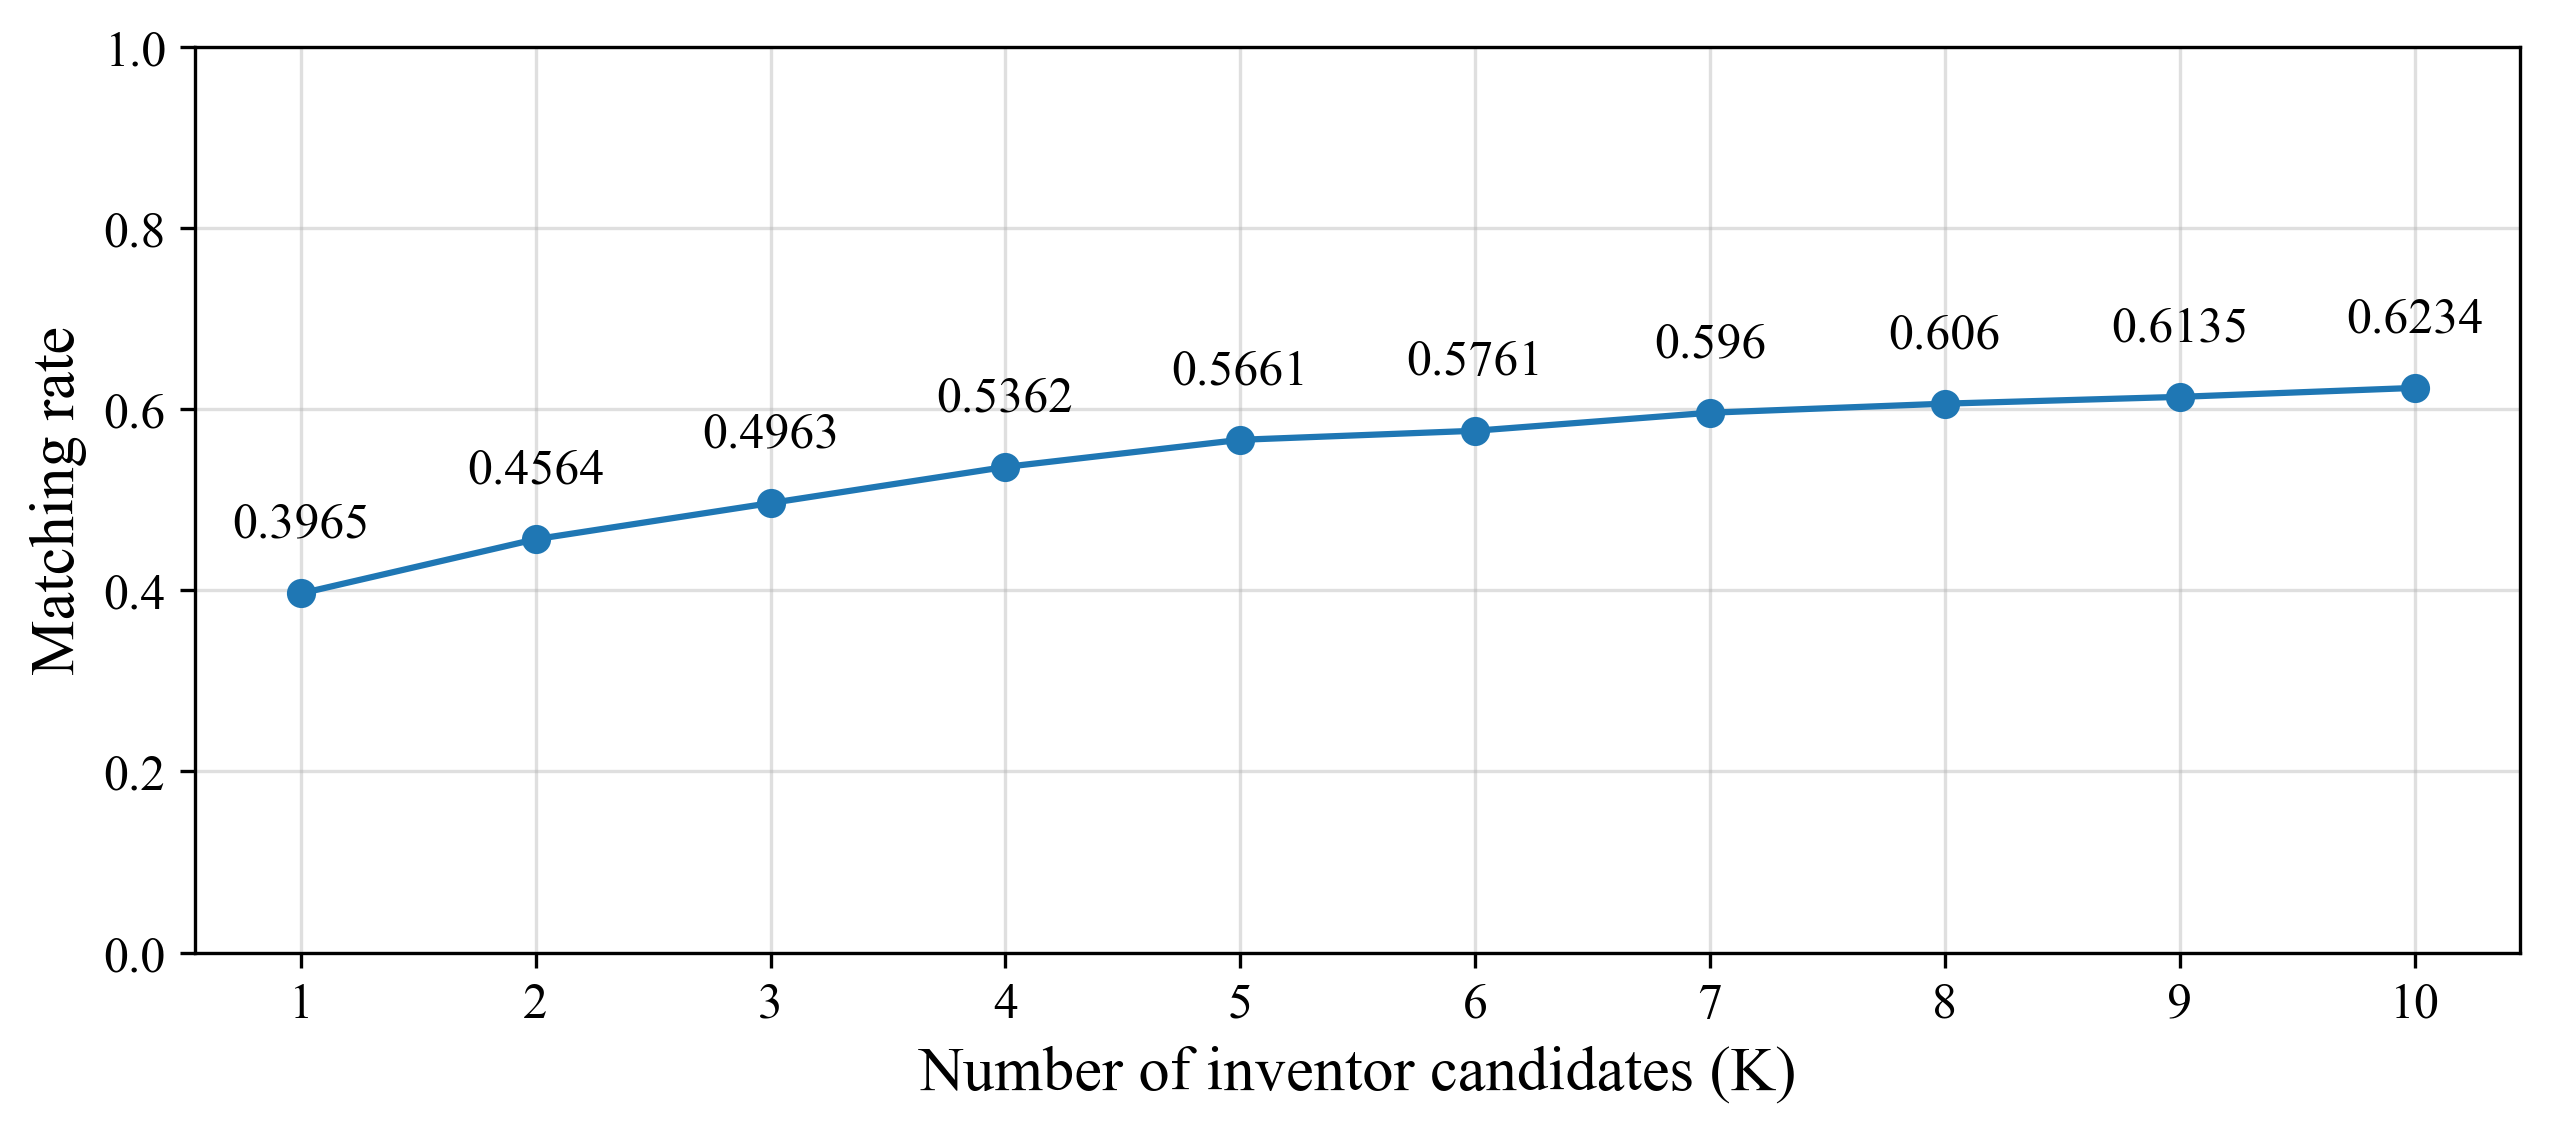

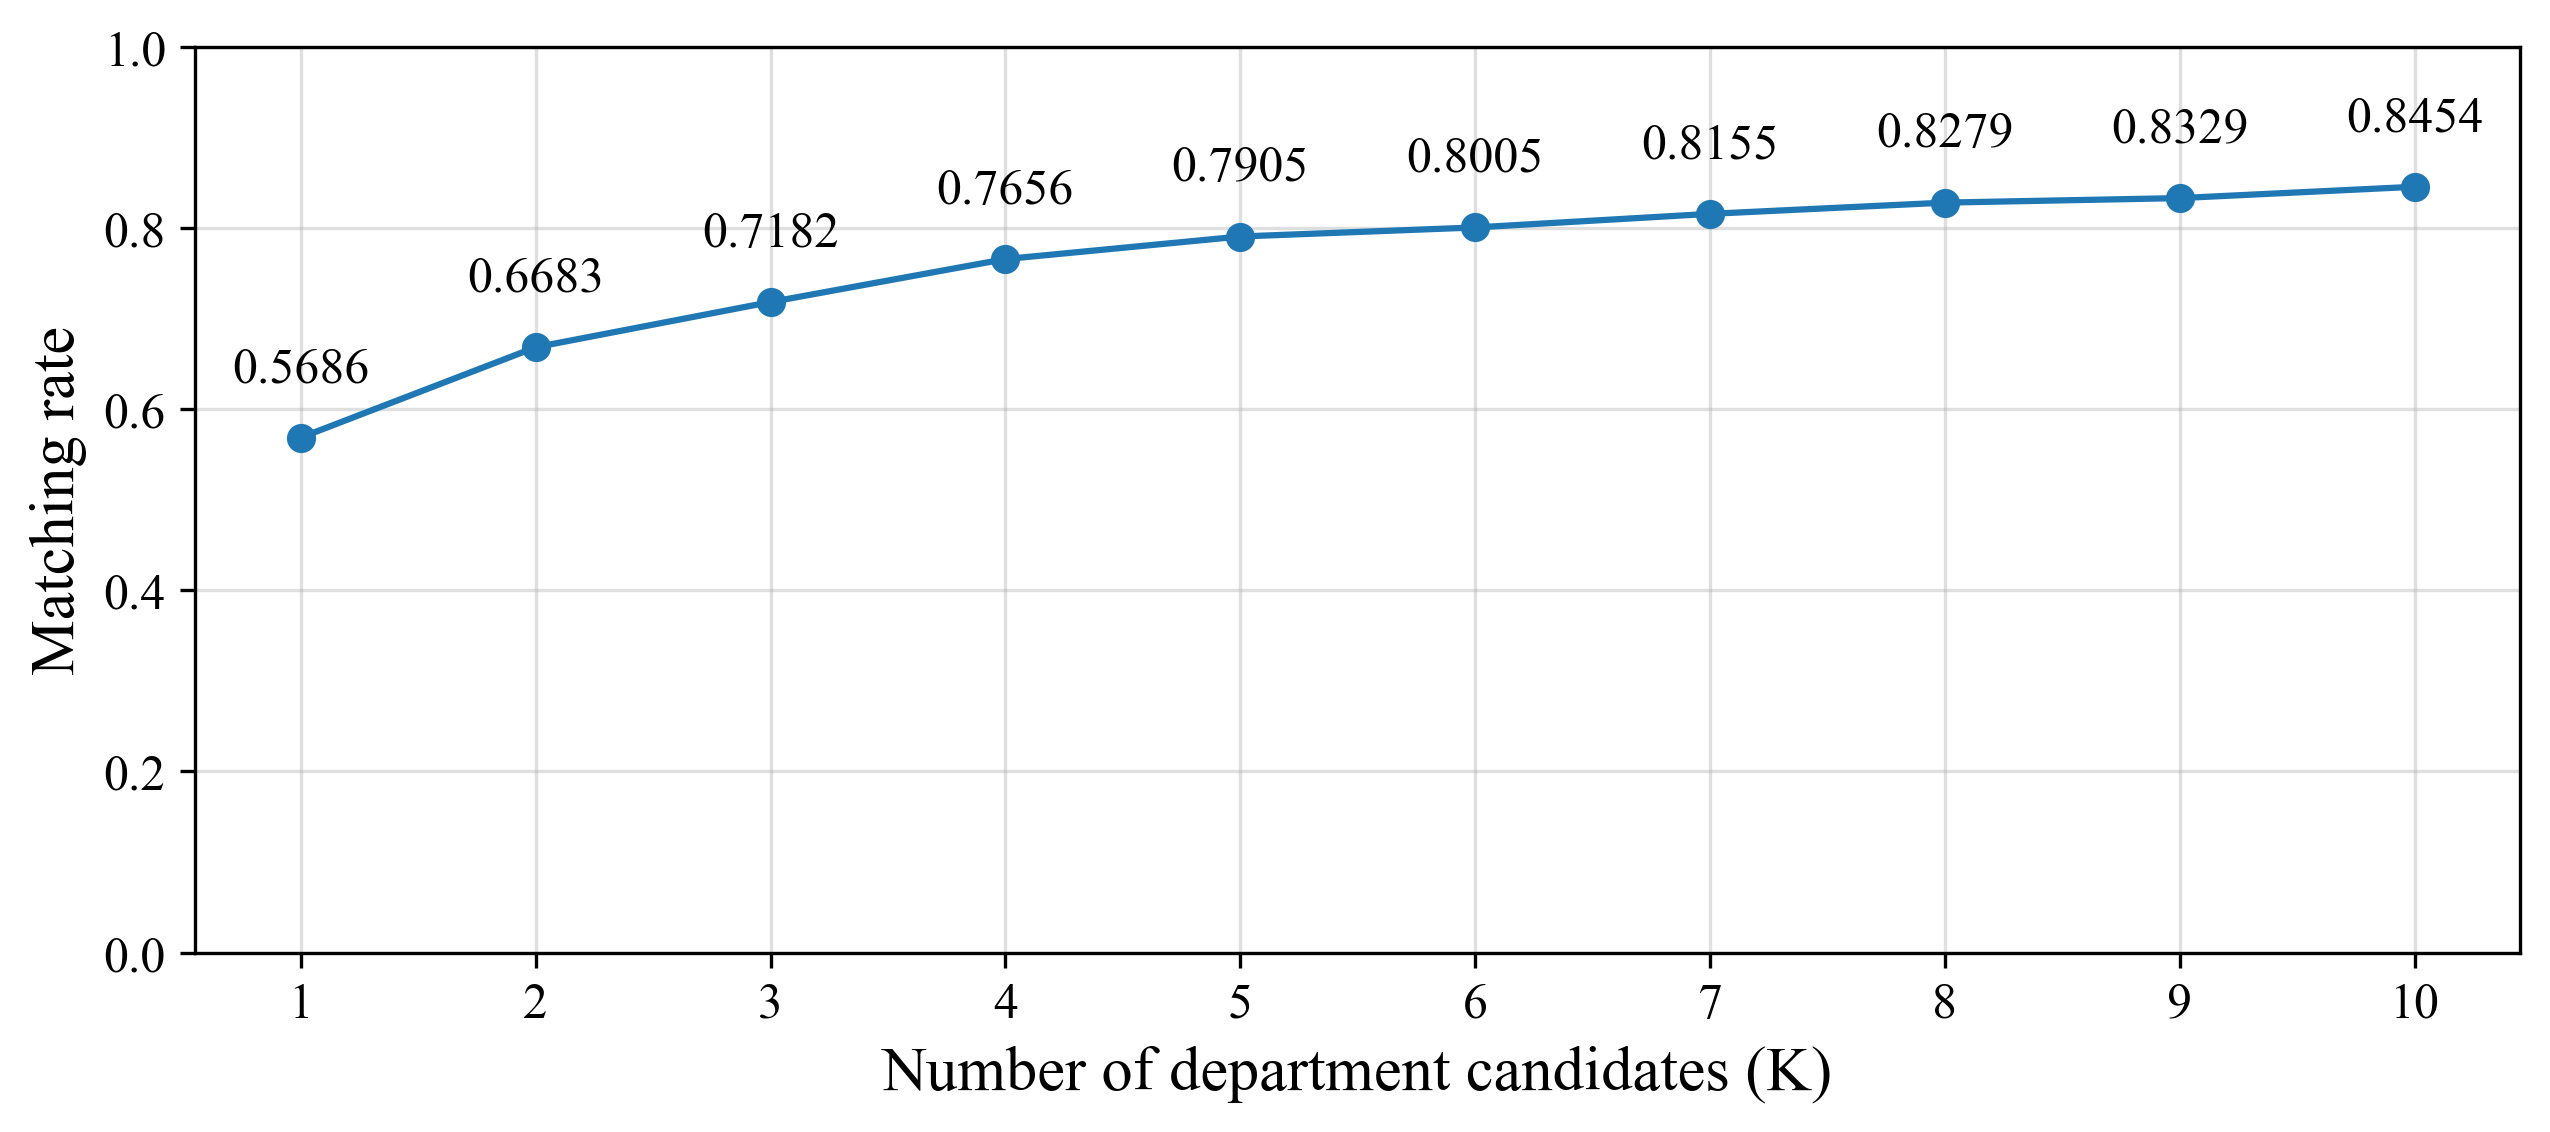

In [546]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1])
ax.set_xlabel('Number of inventor candidates (K)', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1])
ax2.set_xlabel('Number of department candidates (K)', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [ ]:
def get_result(method='avg'):
    print(f"For METHOD {method}")
    
    vec_tech = calc_vec(ft_model, list_tech, method=method, list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method=method, list_total=list_total)
    top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=10)

    idx = 16
    matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
    for i in range(len(top_candidates[index_tech[idx]]['title'])):
        matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
    matchmaking_example = matchmaking_example.T

    display(matchmaking_example)
    
    # Matching ratio
    matching_rate = {'inventor': [], 'department': []}
    for k in range(1,11):
        print("For top",k)
        top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=k)
        eval_matched = {}
        cnt_matched = {}
        cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        for id_target in tqdm(vec_tech.index):
            if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
                cnt_matched['inventor'].loc[id_target] += 1
            if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
                cnt_matched['department'].loc[id_target] += 1
        eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
        eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
        print("Hit ratio (inventor):", eval_matched['inventor'])
        print("Hit ratio (department):", eval_matched['department'])
        print("\n")
        matching_rate['inventor'].append(eval_matched['inventor'])
        matching_rate['department'].append(eval_matched['department'])
        
    # %matplotlib inline
    plt.rcParams['font.family'] = 'Times New Roman'

    fig, ax = plt.subplots(figsize=(10,4), dpi=300)
    ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['inventor']):
        ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of inventor candidates', fontsize=15)
    ax.set_ylabel('Matching rate', fontsize=15)
    ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
    ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Inventor.jpg")

    fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
    ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['department']):
        ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
    ax2.set_ylim([0,1])
    ax2.set_xlabel('Number of departments', fontsize=15)
    ax2.set_ylabel('Matching rate', fontsize=15)
    ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
    ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax2.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Department.jpg")
    print("-"*50)

In [ ]:
methods = ['avg', 'sum', 'sif', 'sif_weight']
for method in methods:
    get_result(method=method)